In [1]:
import pandas as pd
import json
import re
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/conversations.csv', converters={"annotated_gaps": literal_eval, "prompts": literal_eval, "answers": literal_eval})

In [3]:
open_conversations_df = df[df['status'] == 'open'].drop(columns=['status'])
closed_conversations_df = df[df['status'] == 'closed'].drop(columns=['status'])
open_conversations_df.head()

,conversation_id,annotated_gaps,prompts,answers,processed_style,prompts_fulltext,answers_fulltext
2,5,"[{missing specification, missing context}, {mi...","[https://github.com/arakoodev/EdgeChains, can ...",[Finished browsingShow workHide workEdgeChains...,directive prompting,https://github.com/arakoodev/EdgeChains can th...,"Finished browsingShow workHide workEdgeChains,..."
3,6,"[{missing context, unclear instruction}, {No g...",[DeviceData.jsJavaScriptThe attached Next.js p...,[The error messages you provided give insight ...,chain-of-thought (cot),DeviceData.jsJavaScriptThe attached Next.js pa...,The error messages you provided give insight i...
4,7,"[{No gap}, {multiple context, unclear instruct...","[how to make pdf downloader through HTML , CSS...","[Creating a PDF downloader through HTML, CSS, ...",directive prompting,"how to make pdf downloader through HTML , CSS ...","Creating a PDF downloader through HTML, CSS, J..."
7,12,[{No gap}],[I have a django and rasa application (rasa is...,[If you want to set a URL for the Rasa applica...,directive prompting,I have a django and rasa application (rasa is ...,If you want to set a URL for the Rasa applicat...
8,14,"[{missing specification, missing context}, {mi...",[Can I use local storage in the browser to sto...,"[Yes, you can use the browser's local storage ...",chain-of-thought (cot),Can I use local storage in the browser to stor...,"Yes, you can use the browser's local storage t..."


In [4]:
len(open_conversations_df)

171

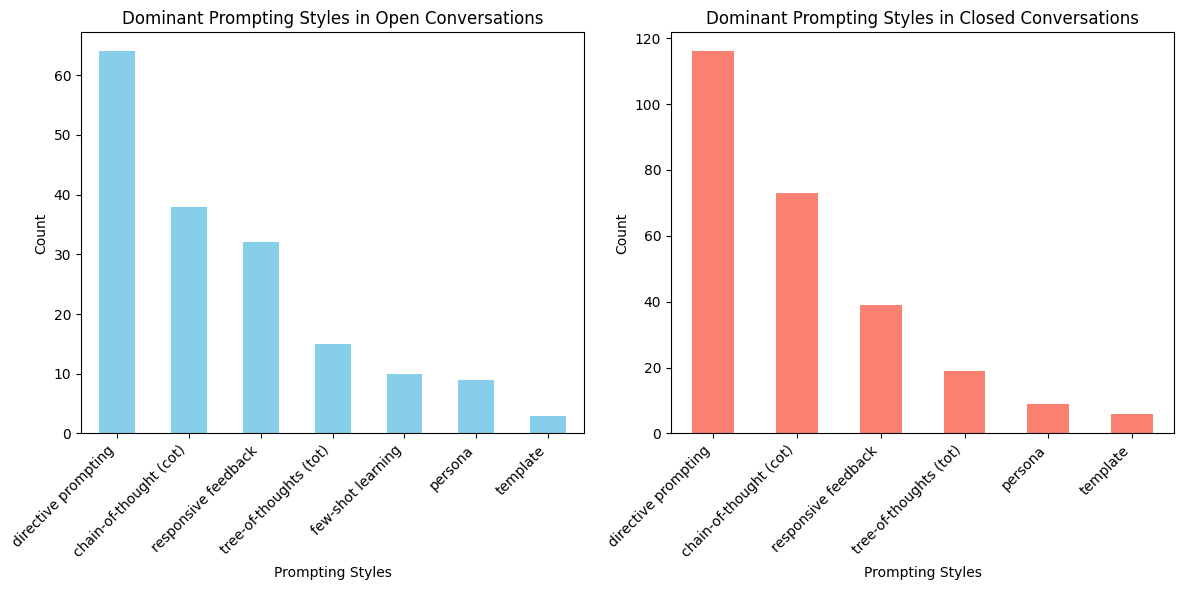

In [5]:
# Step 1: Count the occurrences of each style in the open conversations
open_style_counts = open_conversations_df['processed_style'].value_counts()

# Step 2: Count the occurrences of each style in the closed conversations
closed_style_counts = closed_conversations_df['processed_style'].value_counts()

# Step 3: Create bar charts for open and closed conversations
plt.figure(figsize=(12, 6))

# Bar chart for open conversations
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
open_style_counts.plot(kind='bar', color='skyblue')
plt.title('Dominant Prompting Styles in Open Conversations')
plt.xlabel('Prompting Styles')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Bar chart for closed conversations
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
closed_style_counts.plot(kind='bar', color='salmon')
plt.title('Dominant Prompting Styles in Closed Conversations')
plt.xlabel('Prompting Styles')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Step 4: Adjust layout and display
plt.tight_layout()
plt.show()

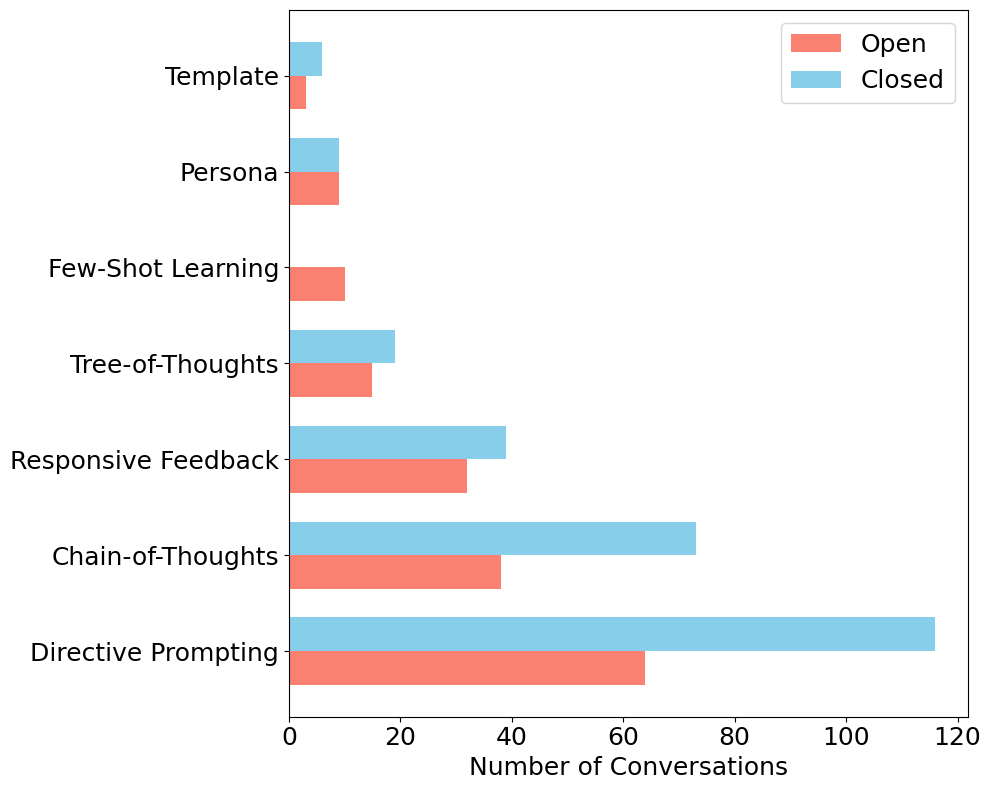

In [6]:
# Step 1: Count the occurrences of each style in the open and closed conversations
open_style_counts = open_conversations_df['processed_style'].value_counts()
closed_style_counts = closed_conversations_df['processed_style'].value_counts()

# Step 2: Combine the counts into a single DataFrame, filling missing values with 0
combined_counts = pd.DataFrame({'Open': open_style_counts, 'Closed': closed_style_counts}).fillna(0)

# Define a dictionary with the old and new names
name_changes = {
    "chain-of-thought (cot)": "Chain-of-Thoughts",
    "cognitive verifier": "Cognitive Verifier",
    "directive prompting": "Directive Prompting",
    "few-shot learning": "Few-Shot Learning",
    "persona": "Persona",
    "responsive feedback": "Responsive Feedback",
    "template": "Template",
    "tree-of-thoughts (tot)": "Tree-of-Thoughts"
}

# Rename the index
combined_counts.rename(index=name_changes, inplace=True)

# Sort by the total number of conversations across Open and Closed
combined_counts = combined_counts.sort_values(by='Open', ascending=False)

# Step 3: Create a horizontal bar chart
plt.figure(figsize=(10, 8))  # Adjust the figure size for a horizontal plot
bar_width = 0.35  # Width of the bars
index = np.arange(len(combined_counts))  # The y locations for the groups

# Bar chart for open conversations
plt.barh(index, combined_counts['Open'], bar_width, label='Open', color='salmon')

# Bar chart for closed conversations, offset by the width of the bars
plt.barh(index + bar_width, combined_counts['Closed'], bar_width, label='Closed', color='skyblue')

# Step 4: Add labels, title, and adjust ticks
plt.xlabel('Number of Conversations', fontsize=18)
# plt.ylabel('Prompting Styles', fontsize=15)
plt.yticks(index + bar_width / 2, combined_counts.index, fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=18, loc='upper right', frameon=True)

# Step 5: Display the plot
plt.tight_layout()
plt.savefig('styles.png', dpi=300)
plt.show()


In [7]:
from scipy.stats import mannwhitneyu

# Reindex counts to ensure both series have the same styles
combined_styles = open_style_counts.index.union(closed_style_counts.index)

# Create arrays for both open and closed counts
open_counts = open_style_counts.reindex(combined_styles, fill_value=0).values
closed_counts = closed_style_counts.reindex(combined_styles, fill_value=0).values

# Step 6: Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(open_counts, closed_counts, alternative='two-sided')

# Step 7: Display results
print(f'Mann-Whitney U statistic: {stat}')
print(f'p-value: {p_value}')

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the styles in open and closed conversations.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the styles in open and closed conversations.")

Mann-Whitney U statistic: 22.5
p-value: 0.8478409541795124
Fail to reject the null hypothesis: There is no significant difference between the styles in open and closed conversations.


In [12]:
from scipy.stats import ttest_ind

# Reindex counts to ensure both series have the same styles
combined_styles = open_style_counts.index.union(closed_style_counts.index)

# Create arrays for both open and closed counts
open_counts = open_style_counts.reindex(combined_styles, fill_value=0).values
closed_counts = closed_style_counts.reindex(combined_styles, fill_value=0).values

# Step 6: Perform the Mann-Whitney U test
stat, p_value = ttest_ind(open_counts, closed_counts, alternative='two-sided')

# Step 7: Display results
print(f'ttest_ind U statistic: {stat}')
print(f'p-value: {p_value}')

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the styles in open and closed conversations.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the styles in open and closed conversations.")

ttest_ind U statistic: -0.7177156124977295
p-value: 0.48667040048937205
Fail to reject the null hypothesis: There is no significant difference between the styles in open and closed conversations.


In [11]:
from scipy.stats import shapiro

# Step 1: Perform the Shapiro-Wilk test for normality on open_counts
stat_open, p_value_open = shapiro(open_counts)
print(f'Open counts - Shapiro-Wilk statistic: {stat_open}, p-value: {p_value_open}')

# Step 2: Perform the Shapiro-Wilk test for normality on closed_counts
stat_closed, p_value_closed = shapiro(closed_counts)
print(f'Closed counts - Shapiro-Wilk statistic: {stat_closed}, p-value: {p_value_closed}')

# Step 3: Interpret the results
alpha = 0.05
if p_value_open < alpha:
    print("Open counts are not normally distributed.")
else:
    print("Open counts are normally distributed.")

if p_value_closed < alpha:
    print("Closed counts are not normally distributed.")
else:
    print("Closed counts are normally distributed.")


Open counts - Shapiro-Wilk statistic: 0.8888124227523804, p-value: 0.2685255706310272
Closed counts - Shapiro-Wilk statistic: 0.8538612127304077, p-value: 0.1332722306251526
Open counts are normally distributed.
Closed counts are normally distributed.


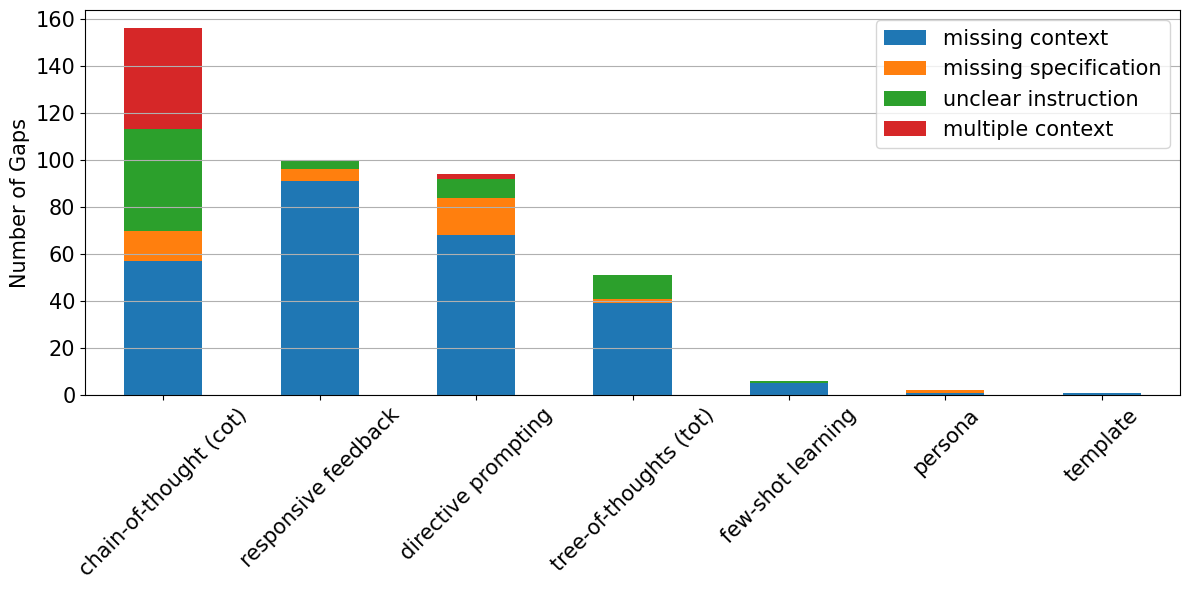

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the gap categories
categories = ['missing context', 'missing specification', 'unclear instruction', 'multiple context']

# Create a list to store DataFrames for each style's gap counts
open_gap_counts = []

# Loop through each processed style and count the occurrences of each gap category
for style in open_conversations_df['processed_style'].unique():
    # Filter the DataFrame for the current style
    style_df = open_conversations_df[open_conversations_df['processed_style'] == style]
    
    # Initialize a count dictionary for this style
    gap_counts = {category: 0 for category in categories}
    
    # Count the gaps in annotated_gaps
    for gaps in style_df['annotated_gaps']:
        for gap in gaps:
            for g in gap:
                if g in categories:
                    gap_counts[g] += 1
    
    # Append the counts to the list as a DataFrame
    open_gap_counts.append(pd.Series(gap_counts, name=style))

# Concatenate the list of Series into a single DataFrame
open_gap_per_style = pd.concat(open_gap_counts, axis=1).fillna(0).T

# Calculate the total number of gaps per style by summing across all categories
open_gap_per_style['total_gaps'] = open_gap_per_style.sum(axis=1)

# Sort the DataFrame by the total number of gaps in descending order
open_gap_per_style_sorted = open_gap_per_style.sort_values(by='total_gaps', ascending=False)

# Drop the 'total_gaps' column after sorting as it's no longer needed for plotting
open_gap_per_style_sorted = open_gap_per_style_sorted.drop(columns=['total_gaps'])

# Plotting the bar chart for open issues in descending order
open_gap_per_style_sorted.plot(kind='bar', stacked=True, figsize=(12, 6))
# plt.title('Number of Gaps per Prompt Style in Open Conversations')
# plt.xlabel('Prompt Styles')
plt.ylabel('Number of Gaps', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=45, fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

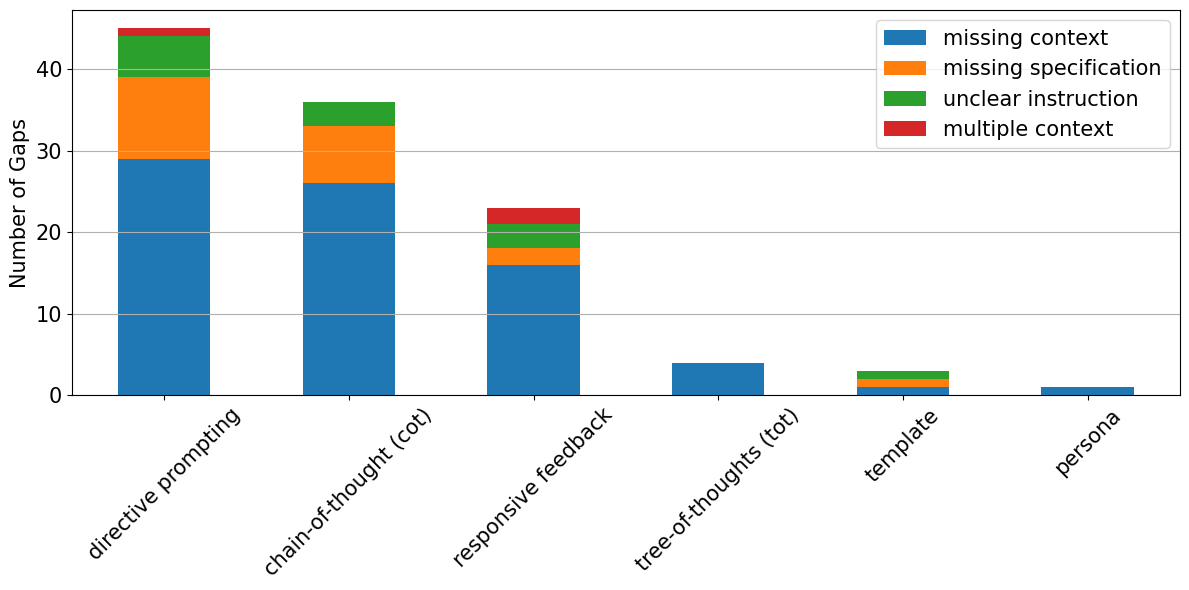

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the gap categories
categories = ['missing context', 'missing specification', 'unclear instruction', 'multiple context']

# Create a list to store DataFrames for each style's gap counts
closed_gap_counts = []

# Loop through each processed style and count the occurrences of each gap category
for style in closed_conversations_df['processed_style'].unique():
    # Filter the DataFrame for the current style
    style_df = closed_conversations_df[closed_conversations_df['processed_style'] == style]
    
    # Initialize a count dictionary for this style
    gap_counts = {category: 0 for category in categories}
    
    # Count the gaps in annotated_gaps
    for gaps in style_df['annotated_gaps']:
        for gap in gaps:
            for g in gap:
                if g in categories:
                    gap_counts[g] += 1
    
    # Append the counts to the list as a DataFrame
    closed_gap_counts.append(pd.Series(gap_counts, name=style))

# Concatenate the list of Series into a single DataFrame
closed_gap_per_style = pd.concat(closed_gap_counts, axis=1).fillna(0).T

# Calculate the total number of gaps per style by summing across all categories
closed_gap_per_style['total_gaps'] = closed_gap_per_style.sum(axis=1)

# Sort the DataFrame by the total number of gaps in descending order
closed_gap_per_style_sorted = closed_gap_per_style.sort_values(by='total_gaps', ascending=False)

# Drop the 'total_gaps' column after sorting as it's no longer needed for plotting
closed_gap_per_style_sorted = closed_gap_per_style_sorted.drop(columns=['total_gaps'])

# Plotting the bar chart for closed issues in descending order
closed_gap_per_style_sorted.plot(kind='bar', stacked=True, figsize=(12, 6))
# plt.title('Number of Gaps per Prompt Style in Closed Conversations')
# plt.xlabel('Prompt Styles')
plt.ylabel('Number of Gaps', fontsize=15)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

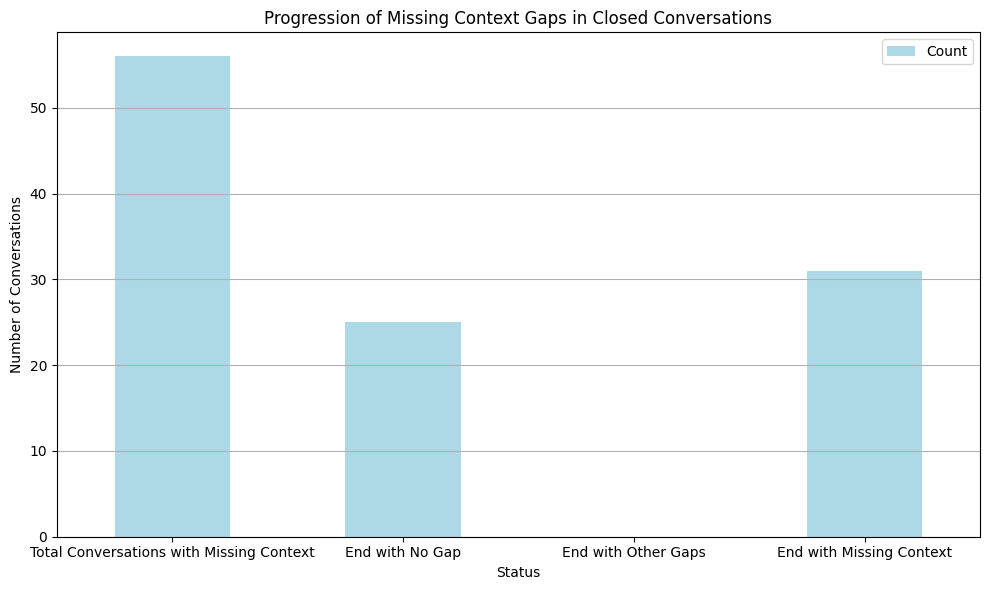

In [14]:
# Initialize counts
total_missing_context = 0
end_no_gap = 0
end_other_gaps = 0
still_missing_context = 0

missing_context_found = False

# Loop through closed conversations to analyze gaps
for gaps in closed_conversations_df['annotated_gaps']:
    for i in range(0, len(gaps)):
        gap = gaps[i]
        # print(gap)
        if 'missing context' in gap:
            total_missing_context += 1
            missing_context_found = True
            break
    if not missing_context_found:
        continue
    # Check the last entry in the gaps list
    # print(gaps[-1])'
    # print("last:" + str(gaps[-1]))
    if 'No gap' in gaps[-1]:
        end_no_gap += 1
    elif 'missing context' not in gaps[-1]:
        end_other_gaps += 1
    elif 'missing context' in gaps[-1]:
        still_missing_context += 1
    missing_context_found = False

# Prepare data for visualization
progression_data = {
    'Total Conversations with Missing Context': total_missing_context,
    'End with No Gap': end_no_gap,
    'End with Other Gaps': end_other_gaps,
    'End with Missing Context': still_missing_context
}

# Create a DataFrame for easier plotting
progression_df = pd.DataFrame.from_dict(progression_data, orient='index', columns=['Count'])

# Plotting the bar chart
progression_df.plot(kind='bar', figsize=(10, 6), color=['lightblue', 'lightgreen', 'salmon'])
plt.title('Progression of Missing Context Gaps in Closed Conversations')
plt.xlabel('Status')
plt.ylabel('Number of Conversations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


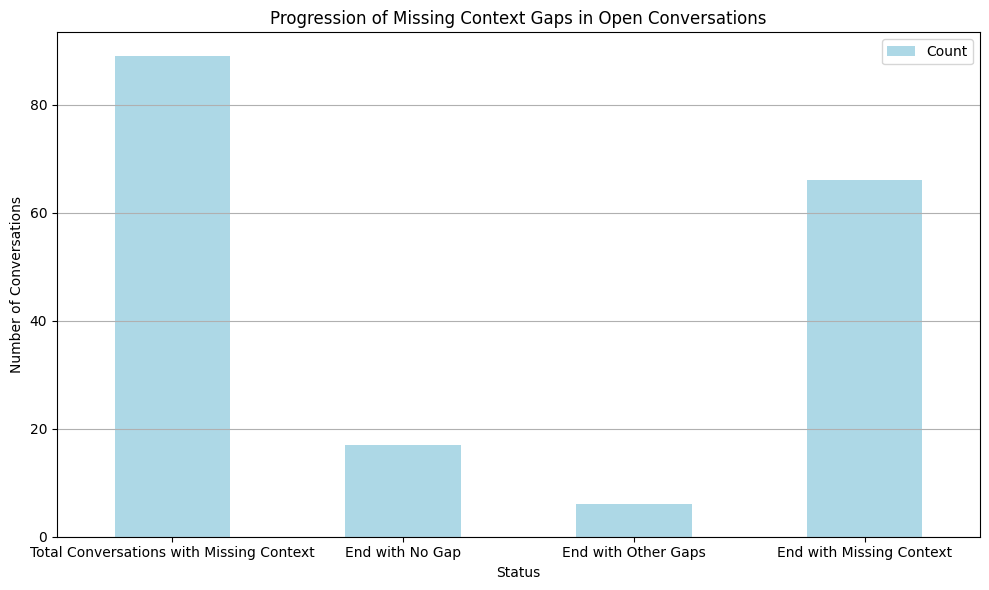

In [15]:
# Initialize counts
total_missing_context = 0
end_no_gap = 0
end_other_gaps = 0
still_missing_context = 0

missing_context_found = False

# Loop through closed conversations to analyze gaps
for gaps in open_conversations_df['annotated_gaps']:
    for i in range(0, len(gaps)):
        gap = gaps[i]
        # print(gap)
        if 'missing context' in gap:
            total_missing_context += 1
            missing_context_found = True
            break
    if not missing_context_found:
        continue
    # Check the last entry in the gaps list
    # print(gaps[-1])'
    # print("last:" + str(gaps[-1]))
    if 'No gap' in gaps[-1]:
        end_no_gap += 1
    elif 'missing context' not in gaps[-1]:
        end_other_gaps += 1
    elif 'missing context' in gaps[-1]:
        still_missing_context += 1
    missing_context_found = False

# Prepare data for visualization
progression_data = {
    'Total Conversations with Missing Context': total_missing_context,
    'End with No Gap': end_no_gap,
    'End with Other Gaps': end_other_gaps,
    'End with Missing Context': still_missing_context
}

# Create a DataFrame for easier plotting
progression_df = pd.DataFrame.from_dict(progression_data, orient='index', columns=['Count'])

# Plotting the bar chart
progression_df.plot(kind='bar', figsize=(10, 6), color=['lightblue', 'lightgreen', 'salmon'])
plt.title('Progression of Missing Context Gaps in Open Conversations')
plt.xlabel('Status')
plt.ylabel('Number of Conversations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


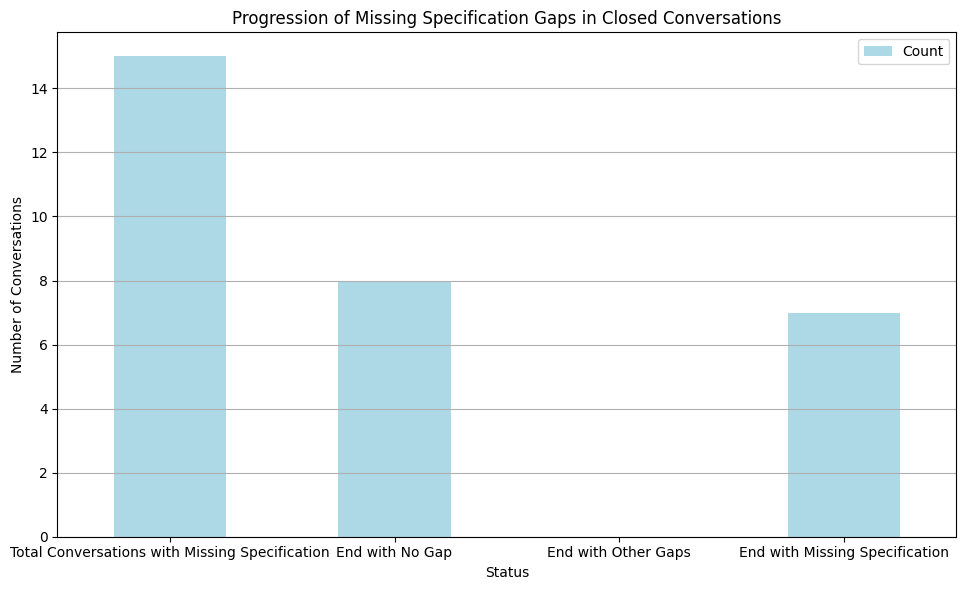

In [16]:
# Initialize counts
total_missing_spec = 0
end_no_gap = 0
end_other_gaps = 0
still_missing_spec = 0

missing_spec_found = False

# Loop through closed conversations to analyze gaps
for gaps in closed_conversations_df['annotated_gaps']:
    for i in range(0, len(gaps)):
        gap = gaps[i]
        # print(gap)
        if 'missing specification' in gap:
            total_missing_spec += 1
            missing_spec_found = True
            break
    if not missing_spec_found:
        continue
    # Check the last entry in the gaps list
    # print(gaps[-1])'
    # print("last:" + str(gaps[-1]))
    if 'No gap' in gaps[-1]:
        end_no_gap += 1
    elif 'missing specification' not in gaps[-1]:
        end_other_gaps += 1
    elif 'missing specification' in gaps[-1]:
        still_missing_spec += 1
    missing_spec_found = False

# Prepare data for visualization
progression_data = {
    'Total Conversations with Missing Specification': total_missing_spec,
    'End with No Gap': end_no_gap,
    'End with Other Gaps': end_other_gaps,
    'End with Missing Specification': still_missing_spec
}

# Create a DataFrame for easier plotting
progression_df = pd.DataFrame.from_dict(progression_data, orient='index', columns=['Count'])

# Plotting the bar chart
progression_df.plot(kind='bar', figsize=(10, 6), color=['lightblue', 'lightgreen', 'salmon'])
plt.title('Progression of Missing Specification Gaps in Closed Conversations')
plt.xlabel('Status')
plt.ylabel('Number of Conversations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


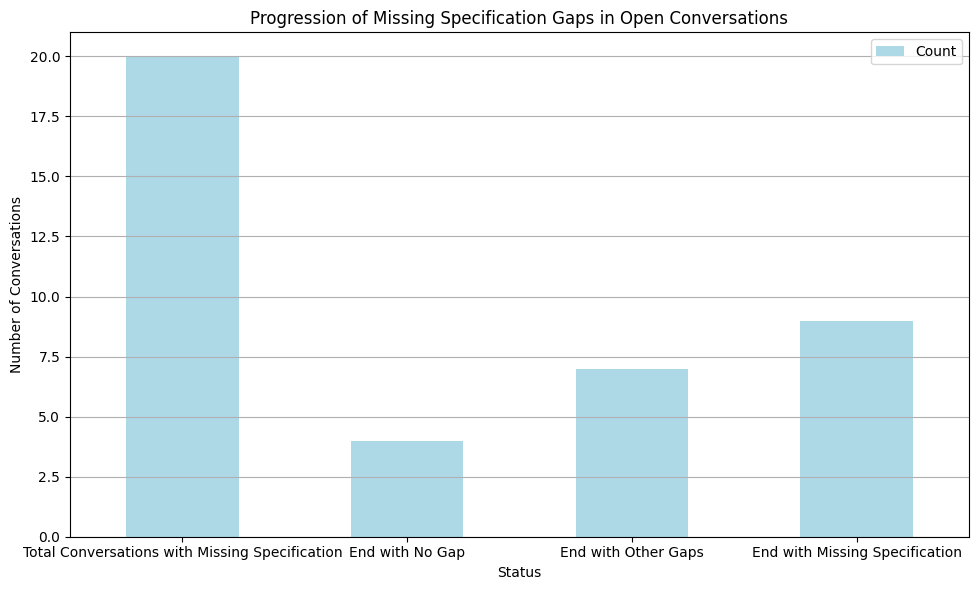

In [17]:
# Initialize counts
total_missing_spec = 0
end_no_gap = 0
end_other_gaps = 0
still_missing_spec = 0

missing_spec_found = False

# Loop through closed conversations to analyze gaps
for gaps in open_conversations_df['annotated_gaps']:
    for i in range(0, len(gaps)):
        gap = gaps[i]
        # print(gap)
        if 'missing specification' in gap:
            total_missing_spec += 1
            missing_spec_found = True
            break
    if not missing_spec_found:
        continue
    # Check the last entry in the gaps list
    # print(gaps[-1])'
    # print("last:" + str(gaps[-1]))
    if 'No gap' in gaps[-1]:
        end_no_gap += 1
    elif 'missing specification' not in gaps[-1]:
        end_other_gaps += 1
    elif 'missing specification' in gaps[-1]:
        still_missing_spec += 1
    missing_spec_found = False

# Prepare data for visualization
progression_data = {
    'Total Conversations with Missing Specification': total_missing_spec,
    'End with No Gap': end_no_gap,
    'End with Other Gaps': end_other_gaps,
    'End with Missing Specification': still_missing_spec
}

# Create a DataFrame for easier plotting
progression_df = pd.DataFrame.from_dict(progression_data, orient='index', columns=['Count'])

# Plotting the bar chart
progression_df.plot(kind='bar', figsize=(10, 6), color=['lightblue', 'lightgreen', 'salmon'])
plt.title('Progression of Missing Specification Gaps in Open Conversations')
plt.xlabel('Status')
plt.ylabel('Number of Conversations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
